#Healthcare Sales Wizard Sales Territory Optimization

Applied Data Science Fall 2024

Prof. Scrivner

Team Members:



*   Erik Kreider
*   Ian Boen
*   Owen Randolph

Notebook by Ian Boen




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('healthcare_sales_dataset.csv')

In [ ]:
df.head()

,product_id,company_id,transaction_id,product_name,product_category,sale_amount,quantity_sold,price_per_unit,uom,address,region,customer_segment,sales_rep_name,date_of_sale,multiple_items
0,PMFTMGPWLK,hospital_20,KH9NHAKRFF,Gauze Sponges,Medical Devices,463.07,85,5.45,packs,"Washington, DC",Northeast,Hospital,Christopher Flores,8/5/2024,0
1,B2L09J6I8B,clinic_3,6XGV4E1D36,Scalpel Blades,Surgical Supplies,387.87,12,32.32,pieces,"Chicago, IL",Midwest,Clinic,John Ponce,4/22/2024,1
2,TLJFSQ5K16,clinic_10,OGEAMK0FW0,Disposable Gloves,Medical Devices,336.95,26,12.96,boxes,"Minneapolis, MN",Midwest,Clinic,Thomas Silva,9/30/2024,1
3,3BDN23AHDX,hospital_2,Y68IXY4B8S,"Syringes, 50ml",Surgical Supplies,254.99,17,15.00,boxes,"Boston, MA",Northeast,Hospital,Megan Chang,5/20/2024,0
4,3BDN23AHDX,clinic_8,3GU73WIOON,"Syringes, 50ml",Medical Devices,291.24,66,4.41,boxes,"Los Angeles, CA",West,Clinic,William Sullivan,5/13/2024,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        10000 non-null  object 
 1   company_id        10000 non-null  object 
 2   transaction_id    10000 non-null  object 
 3   product_name      10000 non-null  object 
 4   product_category  10000 non-null  object 
 5   sale_amount       10000 non-null  float64
 6   quantity_sold     10000 non-null  int64  
 7   price_per_unit    10000 non-null  float64
 8   uom               10000 non-null  object 
 9   address           10000 non-null  object 
 10  region            10000 non-null  object 
 11  customer_segment  10000 non-null  object 
 12  sales_rep_name    10000 non-null  object 
 13  date_of_sale      10000 non-null  object 
 14  multiple_items    10000 non-null  int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 1.1+ MB


In [5]:
df.describe()

,sale_amount,quantity_sold,price_per_unit,multiple_items
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,248.864717,40.619700,9.648196,0.725800
std,135.647920,21.914851,13.229527,0.446133
min,10.060000,1.000000,0.210000,0.000000
25%,133.602500,23.000000,3.430000,0.000000
50%,231.460000,40.000000,6.000000,1.000000
75%,365.560000,57.000000,10.482500,1.000000
max,499.950000,117.000000,198.420000,1.000000


##Exploratory Data Analysis

Distribution and Outlier Analysis

We'll standardize the numerical features for ```sale_amount```, ```quanity_sold```, and ```price_per_unit``` so we can easily compare the boxplots.

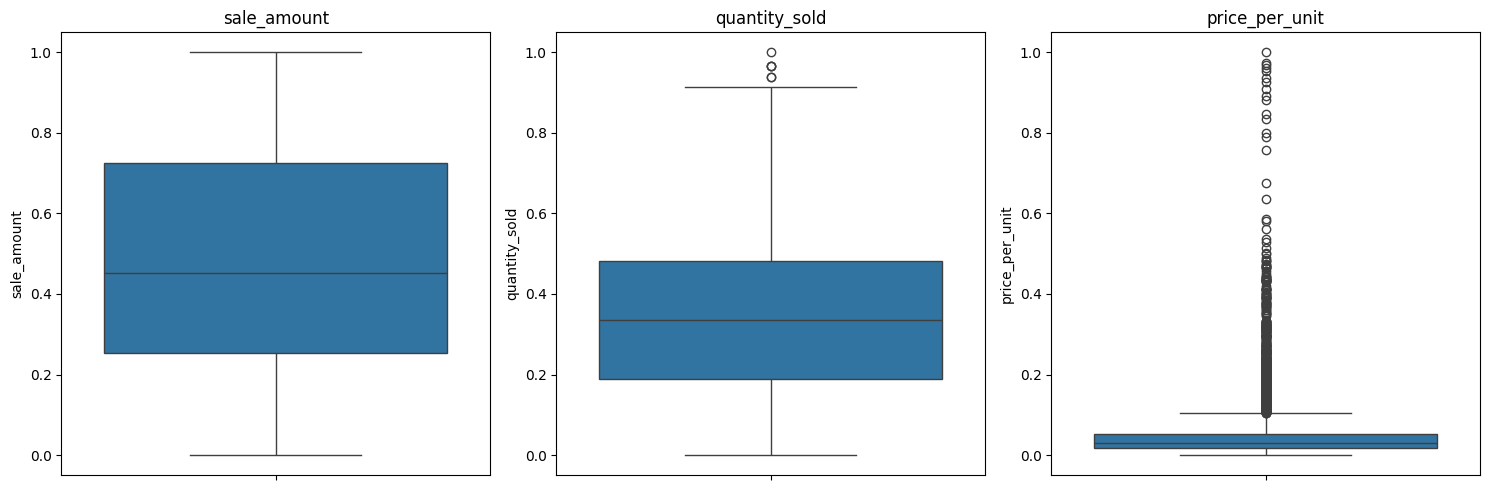

In [15]:
from sklearn.preprocessing import MinMaxScaler

data = {'sale_amount': df['sale_amount'],
        'quantity_sold': df['quantity_sold'],
        'price_per_unit': df['price_per_unit'],}

df = pd.DataFrame(data)

#Normalize Data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# Boxplots for each subplot
features = df_scaled.columns
for i, ax in enumerate(axes):
  sns.boxplot(df_scaled, y=features[i], ax=ax)
  ax.set_title(features[i])

plt.tight_layout()
plt.show()

It looks like ```quantity_sold``` has a few outliers in the upper range, and ```price_per_unit``` appears to have an extensive amount of outliers in the upper range relative to its IQR.

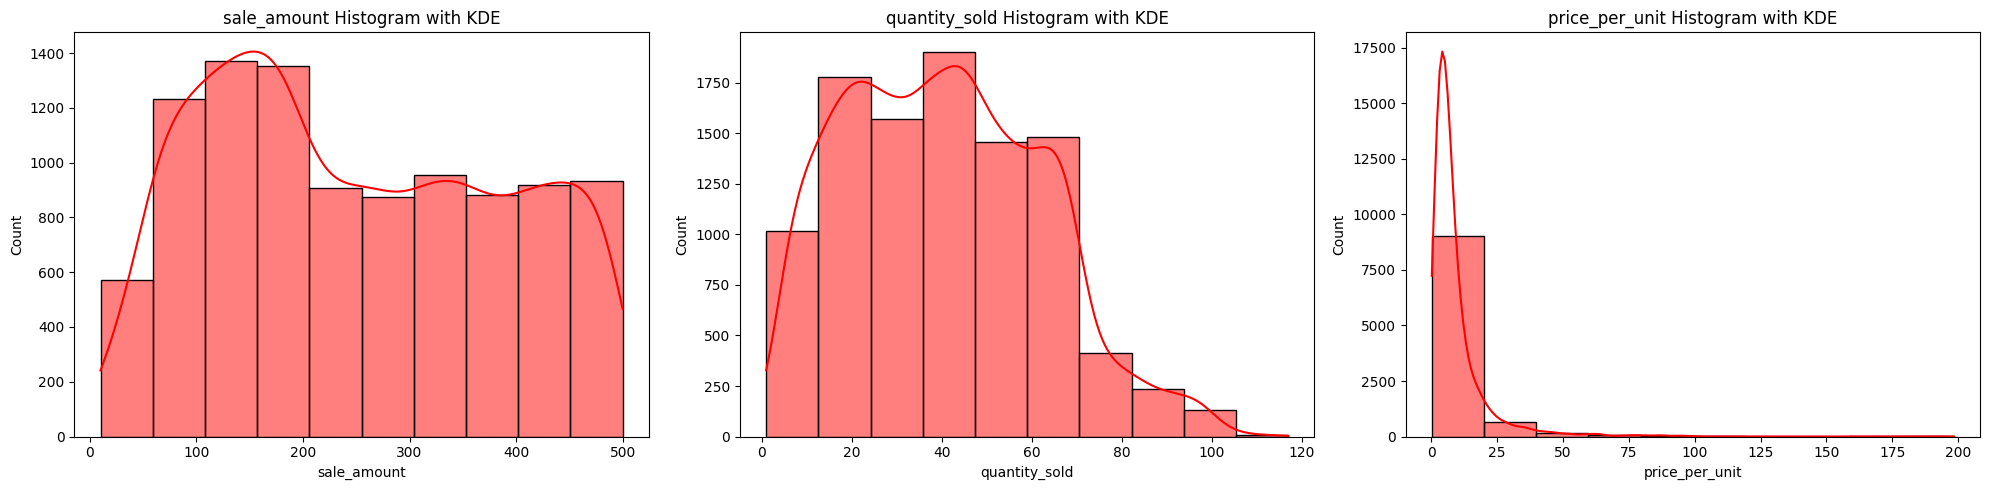

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

features = df.columns
for i, ax in enumerate(axes):
  sns.histplot(df, x=features[i], kde=True, ax=ax, color='red', bins=10)
  ax.set_title(f'{features[i]} Histogram with KDE')

plt.tight_layout()
plt.show()

The ```sale_amount``` is roughly uniform and ```quantity_sold``` has some slight right-skewness. The ```price_per_unit``` is highly right-skewed, indicating several high-priced values on some products as was indicated by the outliers in the boxplots.

Correlation Matrix of Numerical Features

In [16]:
numerical_features = ['quantity_sold', 'price_per_unit', 'sale_amount']

corr_matrix = df[numerical_features].corr()

print(corr_matrix)

                quantity_sold  price_per_unit  sale_amount
quantity_sold        1.000000       -0.493421     0.173113
price_per_unit      -0.493421        1.000000     0.298995
sale_amount          0.173113        0.298995     1.000000


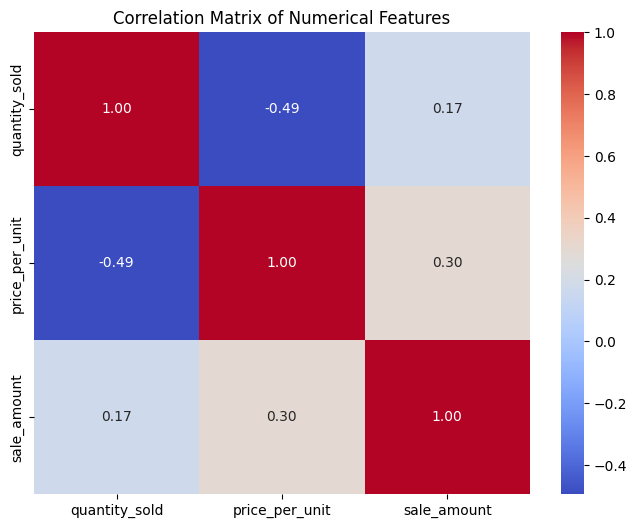

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

There doesn't appear to be a very strong correlation amoung any of the numerical features, the strongest being a -0.49 inverse correlation between ```quantity_sold``` and ```price_per_unit```, which makes sense from the fact that as price of something increases, the lower the volume that item will likely be sold.

Top 10 Products by Sales Amount

In [ ]:
product_sales = df.groupby('product_name')['sale_amount'].sum().sort_values(ascending=False).head(10)
product_sales

,sale_amount
product_name,
"Syringes, 50ml",183544.92
Gauze Sponges,105228.59
Surgical Scalpels,99176.40
IV Tubing Set,97378.86
Catheters,96506.71
Scalpel Blades,96170.81
Suture Kits,95424.80
Forceps,95195.34
Diagnostic Test Strips,94156.89


Top Regions by Sales Amount

In [ ]:
region_sales = df.groupby('region')['sale_amount'].sum().sort_values(ascending=False).head(5)
region_sales

,sale_amount
region,
West,726271.13
South,684853.40
Northeast,415215.75
Pacific Northwest/Mountain,402079.24
Midwest,260227.65


##Visualizing Regional Sales

First, we will split the address column to extract the state only.

In [ ]:
df['state'] = df['address'].str.split(', ').str[-1]

Checking all unique values of states

In [ ]:
print(df['state'].unique())

['DC' 'IL' 'MN' 'MA' 'CA' 'CO' 'TX' 'FL' 'OR' 'GA' 'WA' 'AZ' 'PA' 'NV'
 'NY']


Next, we'll map states to their respective regions and drop the duplicates to ensure each state is only listed once.

In [ ]:
state_to_region = df[['state', 'region']].drop_duplicates().set_index('state')['region'].to_dict()

print(state_to_region)

{'DC': 'Northeast', 'IL': 'Midwest', 'MN': 'Midwest', 'MA': 'Northeast', 'CA': 'West', 'CO': 'Pacific Northwest/Mountain', 'TX': 'South', 'FL': 'South', 'OR': 'Pacific Northwest/Mountain', 'GA': 'South', 'WA': 'Pacific Northwest/Mountain', 'AZ': 'West', 'PA': 'Northeast', 'NV': 'West', 'NY': 'Northeast'}


Mapping regions to the states and creating a heatmap using plotly's choropleth map.

In [ ]:
import plotly.express as px

# Mapping States to Regions
state_sales = [{'state': state, 'sale_amount': region_sales[region]}
               for state, region in state_to_region.items()]

state_sales_df = pd.DataFrame(state_sales)

# Create heatmap
fig = px.choropleth(state_sales_df,
                    locations='state',
                    locationmode='USA-states',
                    color='sale_amount',
                    scope='usa',
                    color_continuous_scale='Reds',
                    title='Sales Heatmap by US Region')

fig.show()

As observed, we are missing the majority of states but get an overall grasp on sales data by region where the West shows the highest level of sales and the Midwest has the lowest.

While it's great to observe what regions have the highest sales, let's also determine the growth rate of the regions to see where sales may be growing the most.

In [ ]:
# Converting date_of_sale to datetime so we can use it for time series analysis
df['date_of_sale'] = pd.to_datetime(df['date_of_sale'])

# Grouping only year and month together
df['year_month'] = df['date_of_sale'].dt.to_period('M')

Summing sales amount by region for each period

In [ ]:
regional_sales = df.groupby(['region', 'year_month'])['sale_amount'].sum().reset_index()

In [ ]:
# Calculating percentage growth rate per region
regional_sales['growth_rate'] = regional_sales.groupby('region')['sale_amount'].pct_change() * 100

Add the new Growth Rate feature back into the Dataset

In [ ]:
df = df.merge(regional_sales[['region', 'year_month', 'growth_rate']], on=['region', 'year_month'], how='left')
df.head(10)

,product_id,company_id,transaction_id,product_name,product_category,sale_amount,quantity_sold,price_per_unit,uom,address,region,customer_segment,sales_rep_name,date_of_sale,multiple_items,state,year_month,growth_rate
0,PMFTMGPWLK,hospital_20,KH9NHAKRFF,Gauze Sponges,Medical Devices,463.07,85,5.45,packs,"Washington, DC",Northeast,Hospital,Christopher Flores,2024-08-05,0,DC,2024-08,18.896409
1,B2L09J6I8B,clinic_3,6XGV4E1D36,Scalpel Blades,Surgical Supplies,387.87,12,32.32,pieces,"Chicago, IL",Midwest,Clinic,John Ponce,2024-04-22,1,IL,2024-04,42.673519
2,TLJFSQ5K16,clinic_10,OGEAMK0FW0,Disposable Gloves,Medical Devices,336.95,26,12.96,boxes,"Minneapolis, MN",Midwest,Clinic,Thomas Silva,2024-09-30,1,MN,2024-09,-13.995380
3,3BDN23AHDX,hospital_2,Y68IXY4B8S,"Syringes, 50ml",Surgical Supplies,254.99,17,15.00,boxes,"Boston, MA",Northeast,Hospital,Megan Chang,2024-05-20,0,MA,2024-05,9.736326
4,3BDN23AHDX,clinic_8,3GU73WIOON,"Syringes, 50ml",Medical Devices,291.24,66,4.41,boxes,"Los Angeles, CA",West,Clinic,William Sullivan,2024-05-13,1,CA,2024-05,-10.677634
5,PMFTMGPWLK,clinic_5,RGCH2BALOQ,Gauze Sponges,Medical Devices,310.83,45,6.91,packs,"Denver, CO",Pacific Northwest/Mountain,Clinic,Lisa Barrera,2024-03-18,1,CO,2024-03,13.310248
6,8LZC91NTUT,hospital_6,K1C7WJLZJM,Surgical Gowns,Surgical Supplies,62.93,17,3.70,packs,"Houston, TX",South,Hospital,Daniel Arnold,2024-05-13,1,TX,2024-05,-11.506480
7,WMHM7GFQTV,hospital_9,V3HQI8R66P,Diagnostic Test Strips,Medical Devices,493.69,52,9.49,boxes,"Miami, FL",South,Hospital,Aaron Snyder,2024-02-26,0,FL,2024-02,-17.454688
8,P6HC1OQ4OR,clinic_15,COEHZHPLYW,Ibuprofen Tablets,Pharmaceuticals,84.81,47,1.80,packs,"Portland, OR",Pacific Northwest/Mountain,Clinic,Juan Campos,2024-05-06,1,OR,2024-05,10.761542
9,18MWNDWCBU,clinic_20,BR82Z7JT80,Surgical Gloves,Surgical Supplies,88.39,50,1.77,boxes,"Washington, DC",Northeast,Clinic,Rebecca Wagner,2024-01-22,1,DC,2024-01,24.492621


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   product_id        10000 non-null  object        
 1   company_id        10000 non-null  object        
 2   transaction_id    10000 non-null  object        
 3   product_name      10000 non-null  object        
 4   product_category  10000 non-null  object        
 5   sale_amount       10000 non-null  float64       
 6   quantity_sold     10000 non-null  int64         
 7   price_per_unit    10000 non-null  float64       
 8   uom               10000 non-null  object        
 9   address           10000 non-null  object        
 10  region            10000 non-null  object        
 11  customer_segment  10000 non-null  object        
 12  sales_rep_name    10000 non-null  object        
 13  date_of_sale      10000 non-null  datetime64[ns]
 14  multiple_items    10000

In [ ]:
# Checking for missing values in growth rate
print(df['growth_rate'].isnull().sum())

577


Fill in Growth Rate Missing Values with Zeros

In [ ]:
df['growth_rate'].fillna(0, inplace=True)
print(df['growth_rate'].isnull().sum())

0


<ipython-input-18-e5e953f44d7e>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





We'll again visualize but this time with the growth rates.

In [ ]:
# First convert the year_month to datetime
regional_sales['year_month'] = regional_sales['year_month'].dt.to_timestamp()

In [ ]:
# Plotly line chart
fig = px.line(regional_sales,
              x='year_month',
              y='growth_rate',
              color='region',
              title='Growth Rate of Sales by Region',
              labels={'growth_rate': 'Growth Rate (%)', 'year_month': 'Date'}
)

# Update layout
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    title_font_size=18,
    legend=dict(title='Region'),
    legend_title_font_size=14,
    legend_font_size=12
)

fig.show()


The line chart reglects plenty of peaks and valleys for all regions over the course of nearly a year but there are some key takeaways. The Pacific Northwest/Mountain region started the highest and also dropped to the negative growth range of the lowest regions over the course of a month. The Midwest region seems to have the most volatile rates, reflecting large variances between peaks and valleys compared to all other regions. It also had the most significant increased of any region, showing up in July 2024, but then dropping back down again to near its lowest negative growth rate. At a surface appearance, the West appears to have the most stability, mostly hovering a little negative or positive in growth.

Next, we will visualize the relationships between some of the variables using multivariate analysis.

###Pairplot Between Price Per Unit, Quantity Sold, and Sale Amount

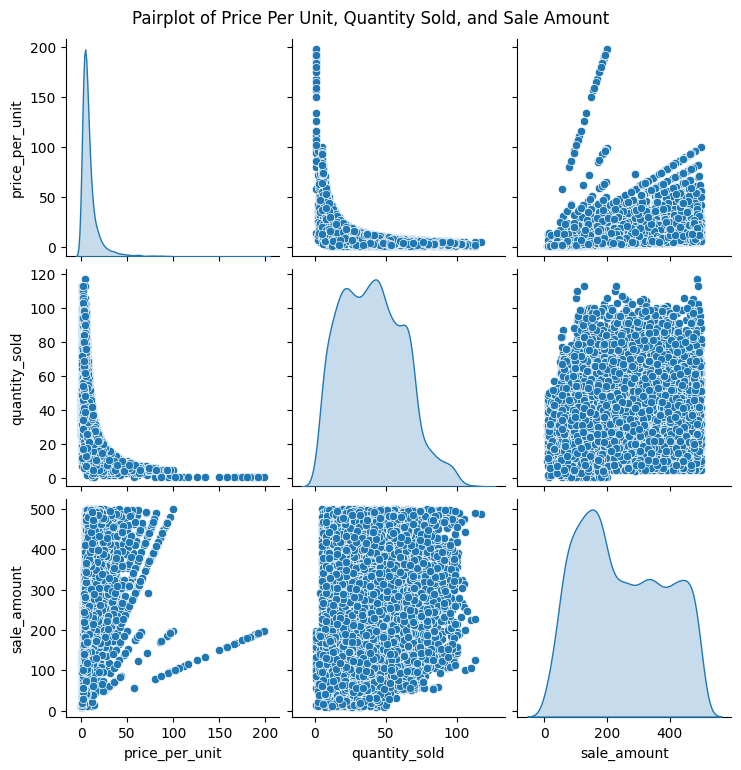

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[['price_per_unit', 'quantity_sold', 'sale_amount']], diag_kind='kde')
plt.suptitle('Pairplot of Price Per Unit, Quantity Sold, and Sale Amount', y=1.02)
plt.show()

There are some clear relationships we can immediately see from the pairplot. It may be stating the obvious to a point, but here we see that the higher the price per unit the lower the quantity of that item sold becomes and vice versa. There also appear to be some linear relationships between price per unit and sale amount where the higher the price per unit the larger the sale amount. This could imply that the quantity sold of certain products may not actually decrease if the price per unit increases, suggesting the product is more non-discretionary or perhaps has fewer alternatives in the market.

##Data Preparation

We're going to set up a target variable first that assigns a territory to a High vs Low sales segment. ```pd.qcut``` assigns the data to bins based on equal quantiles, so when we assign ```q=2``` we ensure that there is an equal split between high and low sales categories.

In [ ]:
# Creating target variable to classify High vs Low
df['sales_category'] = pd.qcut(df['sale_amount'], q=2, labels=['Low', 'High'])
df.head(10)

,product_id,company_id,transaction_id,product_name,product_category,sale_amount,quantity_sold,price_per_unit,uom,address,region,customer_segment,sales_rep_name,date_of_sale,multiple_items,state,year_month,growth_rate,sales_category
0,PMFTMGPWLK,hospital_20,KH9NHAKRFF,Gauze Sponges,Medical Devices,463.07,85,5.45,packs,"Washington, DC",Northeast,Hospital,Christopher Flores,2024-08-05,0,DC,2024-08,18.896409,High
1,B2L09J6I8B,clinic_3,6XGV4E1D36,Scalpel Blades,Surgical Supplies,387.87,12,32.32,pieces,"Chicago, IL",Midwest,Clinic,John Ponce,2024-04-22,1,IL,2024-04,42.673519,High
2,TLJFSQ5K16,clinic_10,OGEAMK0FW0,Disposable Gloves,Medical Devices,336.95,26,12.96,boxes,"Minneapolis, MN",Midwest,Clinic,Thomas Silva,2024-09-30,1,MN,2024-09,-13.995380,High
3,3BDN23AHDX,hospital_2,Y68IXY4B8S,"Syringes, 50ml",Surgical Supplies,254.99,17,15.00,boxes,"Boston, MA",Northeast,Hospital,Megan Chang,2024-05-20,0,MA,2024-05,9.736326,High
4,3BDN23AHDX,clinic_8,3GU73WIOON,"Syringes, 50ml",Medical Devices,291.24,66,4.41,boxes,"Los Angeles, CA",West,Clinic,William Sullivan,2024-05-13,1,CA,2024-05,-10.677634,High
5,PMFTMGPWLK,clinic_5,RGCH2BALOQ,Gauze Sponges,Medical Devices,310.83,45,6.91,packs,"Denver, CO",Pacific Northwest/Mountain,Clinic,Lisa Barrera,2024-03-18,1,CO,2024-03,13.310248,High
6,8LZC91NTUT,hospital_6,K1C7WJLZJM,Surgical Gowns,Surgical Supplies,62.93,17,3.70,packs,"Houston, TX",South,Hospital,Daniel Arnold,2024-05-13,1,TX,2024-05,-11.506480,Low
7,WMHM7GFQTV,hospital_9,V3HQI8R66P,Diagnostic Test Strips,Medical Devices,493.69,52,9.49,boxes,"Miami, FL",South,Hospital,Aaron Snyder,2024-02-26,0,FL,2024-02,-17.454688,High
8,P6HC1OQ4OR,clinic_15,COEHZHPLYW,Ibuprofen Tablets,Pharmaceuticals,84.81,47,1.80,packs,"Portland, OR",Pacific Northwest/Mountain,Clinic,Juan Campos,2024-05-06,1,OR,2024-05,10.761542,Low
9,18MWNDWCBU,clinic_20,BR82Z7JT80,Surgical Gloves,Surgical Supplies,88.39,50,1.77,boxes,"Washington, DC",Northeast,Clinic,Rebecca Wagner,2024-01-22,1,DC,2024-01,24.492621,Low


In [ ]:
print(df['sales_category'].value_counts())

sales_category
Low     5000
High    5000
Name: count, dtype: int64


Standardizing the Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['quantity_sold', 'price_per_unit', 'growth_rate', 'sale_amount']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
df[numerical_features].isnull().sum()

,0
quantity_sold,0
price_per_unit,0
growth_rate,0
sale_amount,0


Before we encode our categorical features, let's perform PCA to make sure we're using the most important features as well as not overfitting with any multicollinearity. I also decided to incorporate this due to getting a 100% accuracy on the classifiers at first, suggesting overfitting.

##PCA

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with 95% variance explained
pca = PCA(n_components=0.95, random_state=42)

# Fit and transform
X_pca = pca.fit_transform(df[numerical_features])

# Explained Variance
print('Explained Variance Ratio:', pca.explained_variance_ratio_)
print('Number of Chosen Components:', pca.n_components_)

Explained Variance Ratio: [0.37838967 0.28927003 0.24816669 0.08417361]
Number of Chosen Components: 4


Principal component 1 explains 38% of the variance, PC2 explains 29%, PC3, explains 25%, and PC4 explains only 8%.

Encoding Categorical Features

In [ ]:
categorical_features = ['region', 'product_name', 'customer_segment']

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded.head()

,product_id,company_id,transaction_id,product_category,sale_amount,quantity_sold,price_per_unit,uom,address,sales_rep_name,...,product_name_Scalpel Blades,product_name_Sterile Drapes,product_name_Surgical Gloves,product_name_Surgical Gowns,product_name_Surgical Masks,product_name_Surgical Scalpels,product_name_Suture Kits,"product_name_Syringes, 50ml",product_name_Vitamin D Capsules,customer_segment_Hospital
0,PMFTMGPWLK,hospital_20,KH9NHAKRFF,Medical Devices,1.579206,2.025226,-0.317351,packs,"Washington, DC",Christopher Flores,...,False,False,False,False,False,False,False,False,False,True
1,B2L09J6I8B,clinic_3,6XGV4E1D36,Surgical Supplies,1.024802,-1.306015,1.713813,pieces,"Chicago, IL",John Ponce,...,True,False,False,False,False,False,False,False,False,False
2,TLJFSQ5K16,clinic_10,OGEAMK0FW0,Medical Devices,0.649399,-0.667147,0.250347,boxes,"Minneapolis, MN",Thomas Silva,...,False,False,False,False,False,False,False,False,False,False
3,3BDN23AHDX,hospital_2,Y68IXY4B8S,Surgical Supplies,0.045158,-1.077848,0.404555,boxes,"Boston, MA",Megan Chang,...,False,False,False,False,False,False,False,True,False,True
4,3BDN23AHDX,clinic_8,3GU73WIOON,Medical Devices,0.312407,1.158190,-0.395967,boxes,"Los Angeles, CA",William Sullivan,...,False,False,False,False,False,False,False,True,False,False


Feature Matrix and Target

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Label encoding for sales_category to convert to numerical labels
df_encoded['sales_category_encoded'] = label_encoder.fit_transform(df_encoded['sales_category'])

features = ['quantity_sold', 'price_per_unit', 'growth_rate', 'sale_amount',
            'region_West','region_South','region_Northeast', 'region_Pacific Northwest/Mountain', 'multiple_items']
X = df_encoded[features]
y = df_encoded['sales_category_encoded']

Splitting the data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

Since we are trying to categorize our data into sales by using high and low sales categories, we want to use classifiers to help us break down where each data point gets categorized. To do this, I'll build both a Decisiong Tree and a RandomForest classifier and compare which classifier performs better to help develop the model that initially performs stronger.

##Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize and train Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

# Perform Cross-Validation with 5 folds
cv_scores = cross_val_score(tree, X_train, y_train, cv=5)

# Make predictions
y_pred_tree = tree.predict(X_test)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

# Cross-Val Results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Decision Tree Accuracy: 0.9616666666666667
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1471
           1       0.96      0.96      0.96      1529

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

Cross-Validation Scores: [0.965      0.96428571 0.97       0.96357143 0.96357143]
Mean Cross-Validation Score: 0.9652857142857142


The decision tree performed fairly well with these hyperparameters across 5 folds with a mean score of over 96%.

##RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=5).fit(X_train, y_train)

# Perform Cross-Validation with 5 folds
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Cross-Val Results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Random Forest Accuracy: 0.9723333333333334
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1471
           1       0.97      0.98      0.97      1529

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

Cross-Validation Scores: [0.97071429 0.97714286 0.975      0.97642857 0.96714286]
Mean Cross-Validation Score: 0.9732857142857144


Our Random Forest Classifier performs slightly better, coming in about 1% higher in accuracy as well as mean cross-validation score versus our Decision Tree model.

Adding in PCA to the models brought down the accuracy from 100% to at most a bit over 97% for the RandomForest classifier. This does seem to suggest there was likely some multicollinearity taking place.

##References

Plotly. (n.d.). *Line charts in Python*. Plotly. Retrieved November 21, 2024, from https://plotly.com/python/line-charts/

Plotly. (n.d.). *Tile Choropleth Maps in Python*. Retrieved November 22, 2024, from https://plotly.com/python/tile-county-choropleth/

##Personal Contribution Statement
This notebook was completed solely by me as part of the larger dashboard we are producing for our team project. We split the dashboard into different sections and each took a piece of the dashboard to work on the respective modeling techniques and tasks. I am developing the dashboard section for optimizing sales territories, while Owen and Erik both have their own respective notebooks for their parts, and will be submitting their respective notebooks separately.